# 1. Importing Dependencies and Data

In [1]:
# Bringing in tensorflow
import tensorflow as tf 
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
for gpu in gpus:
    print(gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
# Bringing tf datasets for fashion mnist
import tensorflow_datasets as tfds 
from matplotlib import pyplot as plt

c:\Users\agyat\anaconda3\envs\tf210\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Use tf datasets api to bring in the data source
ds = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...:  25%|██▌       | 1/4 [00:00<00:02,  1.18 url/s]

Dl Completed...:  50%|█████     | 2/4 [00:01<00:00,  2.05 url/s]

Dl Completed...:  75%|███████▌  | 3/4 [00:09<00:04,  4.21s/ url]

Dl Completed...: 100%|██████████| 4/4 [00:32<00:00, 11.44s/ url]

Dl Completed...: 100%|██████████| 4/4 [00:32<00:00,  8.13s/ url]
                                                                        

Dataset fashion_mnist downloaded and prepared to C:\Users\agyat\tensorflow_datasets\fashion_mnist\3.0.1. Subsequent calls will reuse this data.


In [6]:
ds.as_numpy_iterator().next()['label']

2

# 2. Viz Dataset and Build Dataset

In [4]:
# Data transformation
import numpy as np 

In [8]:
# Making an iterator for going through the dataset
dataiterator = ds.as_numpy_iterator()

In [ ]:
# Iterating
dataiterator.next()

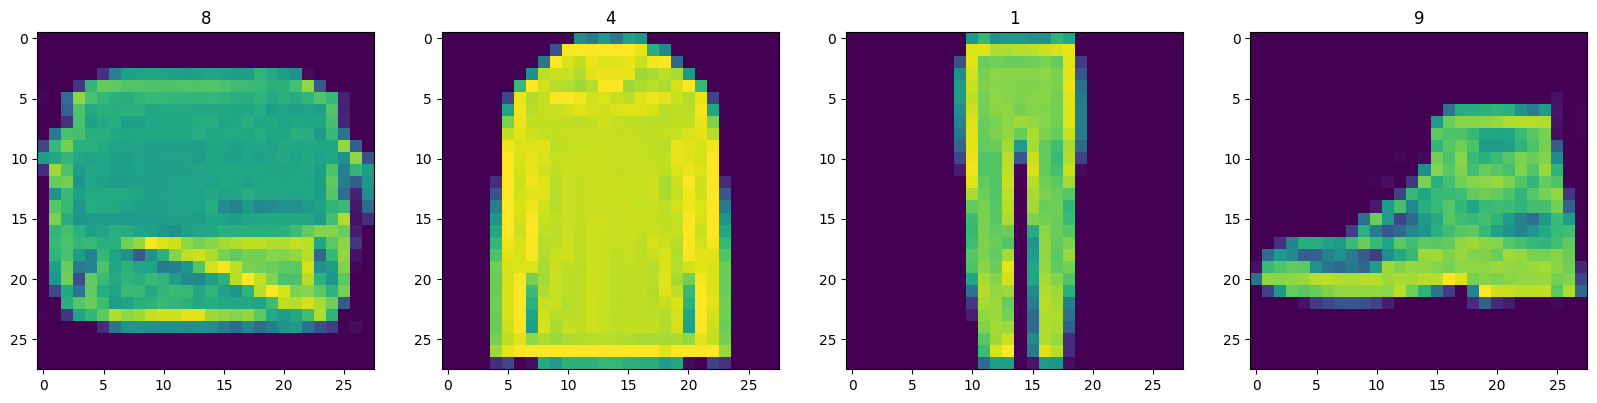

In [11]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    batch = dataiterator.next()
    ax[idx].imshow(np.squeeze(batch['image']))
    ax[idx].title.set_text(batch['label'])

In [5]:
# Scale and return images only
def scale_images(data):
    image = data['image']
    return image / 255

In [6]:
# Reloading the dataset and scaling it
ds = tfds.load('fashion_mnist', split='train')
ds = ds.map(scale_images)
ds = ds.cache()
ds = ds.shuffle(60000)
ds = ds.batch(128)
ds = ds.prefetch(64)

In [7]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

# 3. Building the Neural Network

Making the generator

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [9]:
def build_generator():
    model = Sequential()

    # Generating the image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7, 7, 128)))

    # Upsampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Conv layer to get one channle
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model

In [10]:
test_model = build_generator()
test_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [11]:
generator = build_generator()

In [12]:
img = generator.predict(np.random.randn(4, 128, 1))

1/1 [==============================] - 12s 12s/step


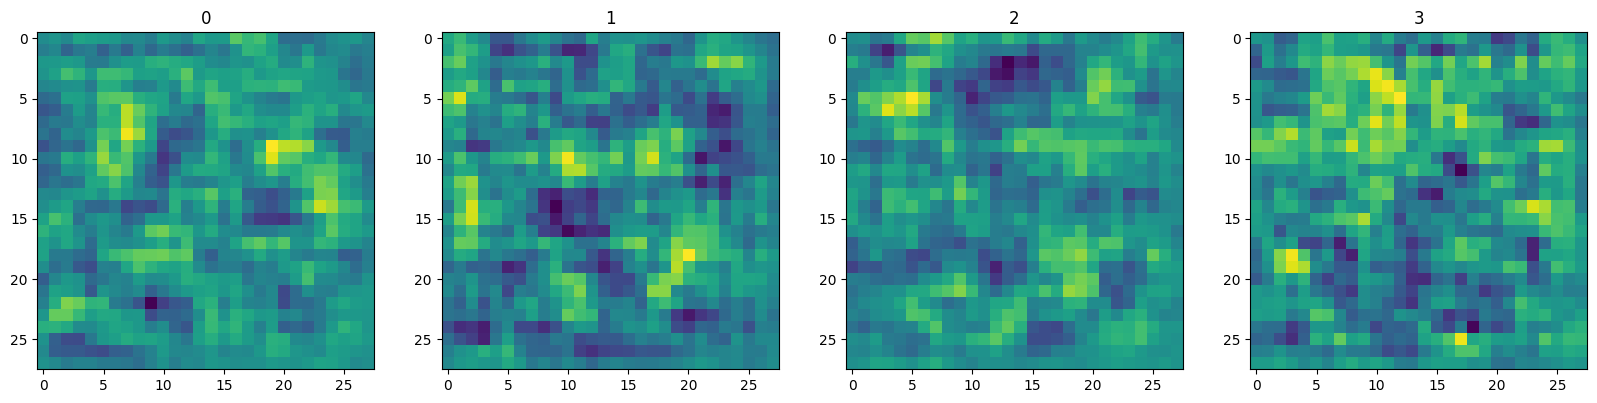

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(img):
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(idx)

Making the discriminator

In [14]:
def build_discriminator():
    model = Sequential()

    # First Conv block
    model.add(Conv2D(32, 5, input_shape = (28, 28, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Second Conv block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Third Conv block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Flatten then passing to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [15]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 128)      

# 4. Construct Training Loop

4.1 Setup Losses and Optimizers

In [17]:
from tensorflow.keras.optimizers import Adam # optimizer for both generator and discriminator
from tensorflow.keras.losses import BinaryCrossentropy # used to be the loss for both

In [18]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

4.2 Build Subclassed Model

In [19]:
from tensorflow.keras.models import Model

In [20]:
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # Create attributes for gen and dis
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        # Getting data
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

        # Training the discriminator
        with tf.GradientTape() as d_tape:
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
        
            # Create labels for real and fake images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # Add some noise to the outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # Calculate loss
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        with tf.GradientTape() as g_tape:
            # Generating images
            gen_images = self.generator(tf.random.normal((128, 128, 1)), training=True)

            # Creating the predicted lables
            predicted_labels = self.discriminator(gen_images, training=False)

            # Calculated loss
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # Apply backpropagation - nn learn
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.d_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        return {'d_loss': total_d_loss, 'g_loss': total_g_loss}

In [21]:
fashgan = FashionGAN(generator, discriminator)
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

4.3 Building Callback

In [22]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [23]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

4.3 Train

In [24]:
hist = fashgan.fit(ds, epochs=20, callbacks=[ModelMonitor()])

Epoch 1/20


  6/469 [..............................] - ETA: 2:17 - d_loss: 0.6955 - g_loss: 0.6773WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1239s vs `on_train_batch_end` time: 0.1441s). Check your callbacks.


469/469 [==============================] - 154s 304ms/step - d_loss: 0.6210 - g_loss: 1.0667
Epoch 2/20
469/469 [==============================] - 142s 304ms/step - d_loss: 0.6500 - g_loss: 0.8460
Epoch 3/20
469/469 [==============================] - 143s 304ms/step - d_loss: 0.6584 - g_loss: 0.8015
Epoch 4/20
469/469 [==============================] - 143s 305ms/step - d_loss: 0.6564 - g_loss: 0.8575
Epoch 5/20
469/469 [==============================] - 143s 306ms/step - d_loss: 0.6343 - g_loss: 0.9135
Epoch 6/20
469/469 [==============================] - 143s 306ms/step - d_loss: 0.6560 - g_loss: 0.8369
Epoch 7/20
469/469 [==============================] - 144s 306ms/step - d_loss: 0.5865 - g_loss: 0.9765
Epoch 8/20
469/469 [==============================] - 144s 306ms/step - d_loss: 0.5459 - g_loss: 1.0496
Epoch 9/20
469/469 [==============================] - 144s 306ms/step - d_loss: 0.5806 - g_loss: 1.2975
Epoch 10/20
469/469 [==============================] - 144s 306ms/step - d_

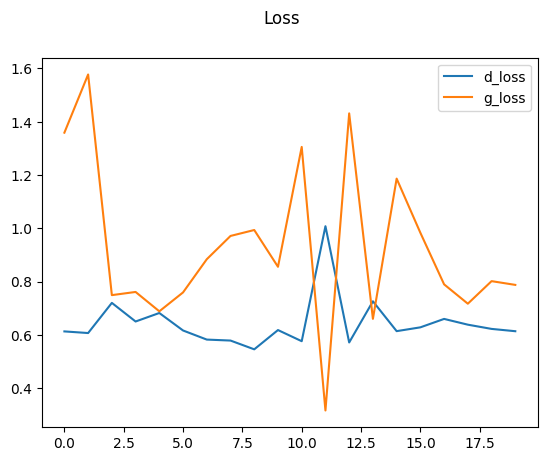

In [25]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

# 5. Test Out the Generator

5.1 Generated Images

In [27]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))
imgs

1/1 [==============================] - 0s 305ms/step


array([[[[2.40542308e-11],
         [3.29154530e-14],
         [1.78658992e-19],
         ...,
         [3.35484545e-33],
         [8.57539878e-18],
         [4.73206405e-11]],

        [[1.32008000e-12],
         [1.88460093e-16],
         [3.82972216e-23],
         ...,
         [0.00000000e+00],
         [5.86425464e-22],
         [9.81397515e-12]],

        [[9.39762892e-19],
         [5.28246654e-25],
         [1.31134311e-33],
         ...,
         [0.00000000e+00],
         [5.53080537e-25],
         [1.32974794e-13]],

        ...,

        [[2.05629420e-11],
         [1.18121723e-12],
         [1.82495078e-11],
         ...,
         [5.01121713e-23],
         [1.61402298e-14],
         [9.03281006e-10]],

        [[3.95684197e-07],
         [9.17807554e-08],
         [5.95878703e-07],
         ...,
         [8.26244238e-13],
         [7.55218199e-09],
         [9.16747740e-06]],

        [[1.94260443e-03],
         [1.18256710e-03],
         [1.09436770e-03],
         ...,
 

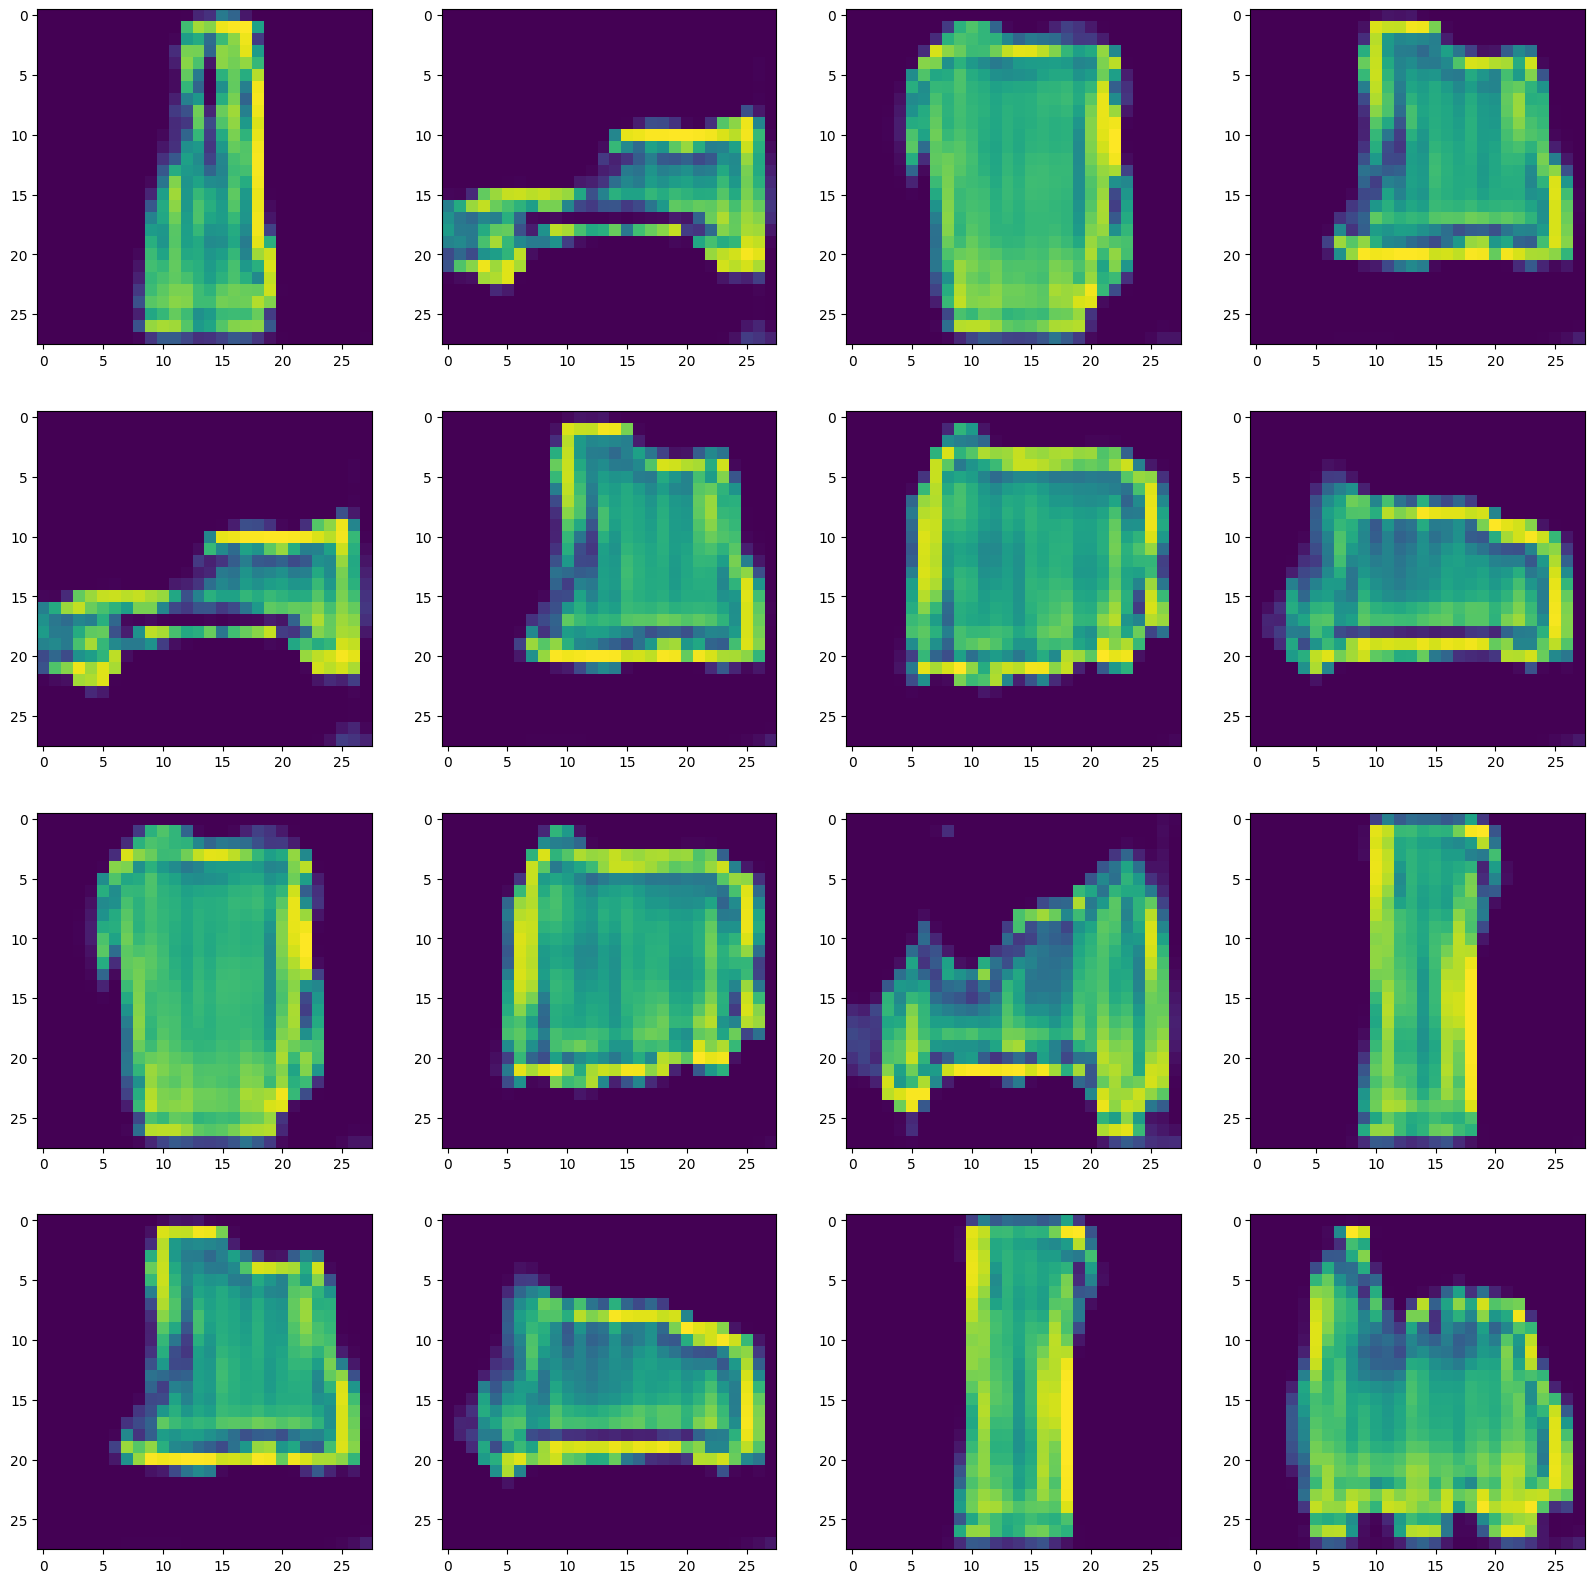

In [29]:
fig, ax, = plt.subplots(ncols=4, nrows=4, figsize=(20, 20))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

5.2 Saveing the Model

In [30]:
generator.save('fashiongenerator.h5')
discriminator.save('fashiondiscriminator.h5')